# Divide and Patch

This notebook defines the functions for dividing an image into 50x50px patches for processing.

In [1]:
# Standard Imports
import numpy as np

# Importing all relevant packages for modeling in keras
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization,Conv2D,MaxPool2D,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model

# Import packages for showing the performance metrics
from sklearn.metrics import confusion_matrix

# Importing local functions
from src import eval_plots

from glob import glob
import cv2
import os
from PIL import Image

# Setting the random seed for reproducability
np.random.seed(123)

In [2]:
# Open full image 
img = Image.open('./images/9037.jpg')

In [3]:

# Opens a image in RGB mode
image_name = '9037'
img = Image.open('./images/'+image_name+'.jpg')
height_num = img.height/50
width_num = img.width/50


In [4]:
height_num

28.0

In [5]:
for i in range(0,int(height_num)):
    for j in range(0,int(width_num)):

        # Setting the points for cropped image
        left = 0 + 50*j
        top = 0 + 50*i
        right = 50 + 50*j
        bottom = 50 + 50*i

        # Cropped image of above dimension
        # (It will not change original image)
        im1 = img.crop((left, top, right, bottom))
        
        # Shows the image in image viewer
        # os.mkdir('./test/9037_split')
        im1.save('./test/9037_split/'+image_name+'_'+str(right)+'_'+str(bottom)+'.png')


In [6]:
data = glob('./test/9037_split/*.png')

In [7]:
len(data)

1260

In [8]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

In [9]:
model = models.load_model('./models/DenseNet201/denseNet201.h5')

In [59]:
def make_prediction(img_path,target_size):
    img = image.load_img(img_path,target_size=target_size)
    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array,axis=0)
    # img_preprocessed = preprocess_input(img_array)
    return float(model.predict(img_batch/255))

In [11]:
img = image.load_img(data[0],(50,50))
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array,axis=0)


In [12]:
predictions = []
for path in data:
    predictions.append(make_prediction(path))

In [13]:
predictions_array = np.array(predictions)

In [14]:
len(predictions_array)

1260

In [15]:
normalized_predictions = (predictions_array - min(predictions_array))/(max(predictions_array) - min(predictions_array))

In [23]:
# Separating file name from the path of the file
files = []
for datum in data:
        files.append(os.path.basename(datum))

# removing the .png from the file names and isolating the x, y positions of the images
x = []
y = []
for file in files:
    # isolating the x and y coordinates of the image and converting to int type
    x.append(int(file.split('_')[1]))
    y.append(int(file.split('_')[2].replace('.png','')))



In [17]:

# Initialize the full image space
full_slide = Image.new('RGB',(max(x)-min(x),max(y)-min(y)),color='#f2f2f5')
count = 0
for datum in data:
    # Isolate the file name
    file = os.path.basename(datum)

    # grab the location of the image from the file
    x = int(file.split('_')[1])
    y = int(file.split('_')[2].replace('.png',''))

    # Load the image in using the cv library
    img = Image.new('RGB',(50,50),color=(int(255*predictions_array[count]),int(255*predictions_array[count]),int(255*predictions_array[count])))
    
    # paste the image into the image space
#     full_slide.paste(img,(x-51,y-51))
#     # paste the image into the image space
    full_slide.paste(img,(x-50,y-50))
    count+=1

In [18]:
full_slide.save('9037_predictions.png')

In [19]:
# Function to change the image size
def changeImageSize(maxWidth, 
                    maxHeight, 
                    image):
    
    widthRatio  = maxWidth/image.size[0]
    heightRatio = maxHeight/image.size[1]

    newWidth    = int(widthRatio*image.size[0])
    newHeight   = int(heightRatio*image.size[1])

    newImage    = image.resize((newWidth, newHeight))
    return newImage

# Take two images for blending them together   
image1 = Image.open("9037_whole_slide.png")
image2 = Image.open("9037_predictions.png")

# Make the images of uniform size
image3 = changeImageSize(800, 500, image1)
image4 = changeImageSize(800, 500, image2)

# Make sure images got an alpha channel
image5 = image3.convert("RGBA")
image6 = image4.convert("RGBA")

# Display the images
image5.show()
image6.show()

# alpha-blend the images with varying values of alpha
alphaBlended1 = Image.blend(image5, image6, alpha=.2)
alphaBlended2 = Image.blend(image5, image6, alpha=.6)

# Display the alpha-blended images
alphaBlended1.show()
alphaBlended2.show()

In [24]:
import pandas as pd
data_dict = {'x':x,'y':y,'Predictions':predictions}
df = pd.DataFrame(data_dict)

In [54]:
x_proba = df.groupby(x).agg(np.mean)
y_proba = df.groupby(y).agg(np.mean).sort_values('x',ascending=True)

In [55]:
x_proba.join(y_proba,how='outer',lsuffix='lft')

,xlft,ylft,Predictionslft,x,y,Predictions
50,50,725,0.123232,1150.0,50.0,0.236638
100,100,725,0.192265,1150.0,100.0,0.370114
150,150,725,0.227194,1150.0,150.0,0.343114
200,200,725,0.245346,1150.0,200.0,0.338697
250,250,725,0.265513,1150.0,250.0,0.353235
300,300,725,0.199657,1150.0,300.0,0.410596
350,350,725,0.212809,1150.0,350.0,0.384651
400,400,725,0.232364,1150.0,400.0,0.387884
450,450,725,0.185502,1150.0,450.0,0.343818
500,500,725,0.191755,1150.0,500.0,0.376807


C:\Users\ajche\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


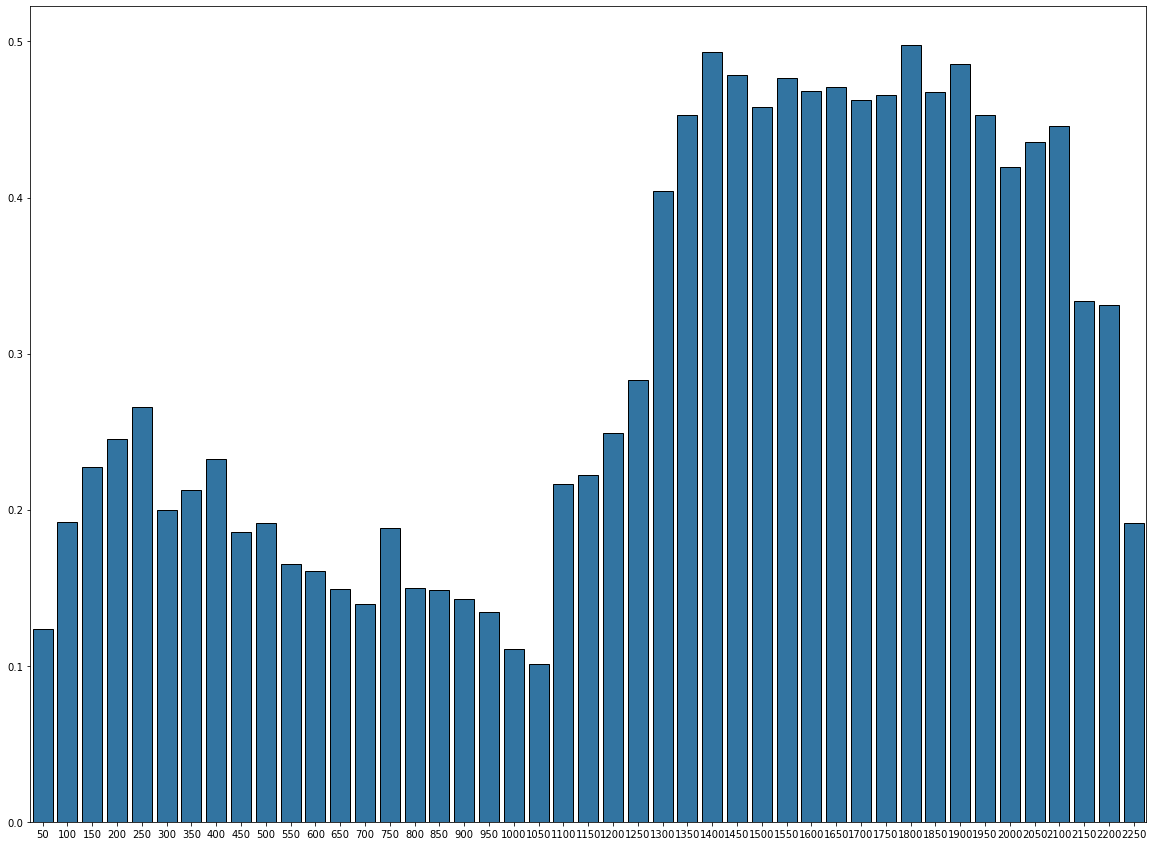

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
fig,ax = plt.subplots(figsize=(20,15))
sns.barplot(x_proba['Predictions'].index,x_proba['Predictions'].values,color='tab:blue',edgecolor='black');

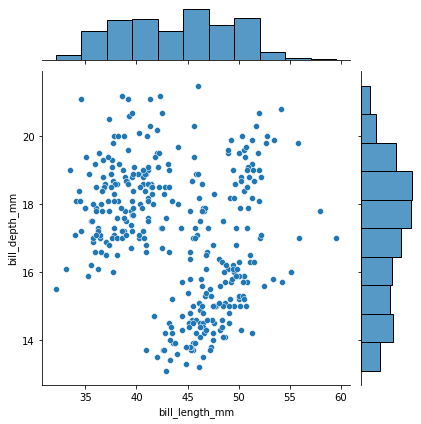

In [33]:
penguins = sns.load_dataset("penguins")
sns.jointplot(data=penguins, x="bill_length_mm", y="bill_depth_mm")

In [34]:
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


In [ ]:
np.mean(predictions)

0.2961771545902131